# Misinformation Analysis

(For thesis)

Steps:
- Scrape Politifact for training data
- Construct multiple classifiers
    - Naive Bayes
    - SVM
    - Google BERT
- Choose the best
- Run headlines through (July - November)
- Select misinformation keywords based off of relevant appearances

## Scraping Politifact

Scrape politifact for the `statement_quote` link text (see screenshot on google doc) and the corresponding rating which is the alt title of the `picture`.

(We might also want the date)

Following https://towardsdatascience.com/scraping-1000s-of-news-articles-using-10-simple-steps-d57636a49755

In [2]:
from bs4 import BeautifulSoup
import urllib.request, sys, time
import requests
import pandas as pd
from dateutil.parser import parse

In [4]:
# url of the page that we want to Scarpe
# +str() is used to convert int datatype of the page no. and concatenate that to a URL for pagination purposes.
page_num = 1
URL = 'https://www.politifact.com/factchecks/list/?page='+str(page_num)

try:
    # this might throw an exception if something goes wrong.
    page = requests.get(URL) 
    
    # this describes what to do if an exception is thrown 
except Exception as e:    
    
    # get the exception information
    error_type, error_obj, error_info = sys.exc_info()      
    
    #print the link that cause the problem
    print('ERROR FOR LINK:', URL)
    
    #print error info and line that threw the exception                          
    print(error_type, 'Line:', error_info.tb_lineno)

In [8]:
# Inspect response code
page.status_code

# Full response as text
page.text

# Check content type
print(page.headers.get("content-type", "unknown"))

text/html; charset=utf-8


The actual data scraper:

In [40]:
# Page 22 covers all of July - Present
n_pages = 22

upperframe=[]  
for page in range(1, n_pages + 1):
    print('processing page :', page)
    URL = 'https://www.politifact.com/factchecks/list/?page='+str(page)
    print(URL)
    
    # an exception might be thrown, so the code should be in a try-except block
    try:
        # use the browser to get the url. This is suspicious command that might blow up.
        page = requests.get(URL)                             # this might throw an exception if something goes wrong.
    
    except Exception as e:                                   # this describes what to do if an exception is thrown
        error_type, error_obj, error_info = sys.exc_info()      # get the exception information
        print('ERROR FOR LINK:',url)                          #print the link that cause the problem
        print(error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
        continue                                              #ignore this page. Abandon this and go back.
    
    time.sleep(2)   
    soup = BeautifulSoup(page.text,'html.parser')
    frame = []
    links = soup.find_all('li',attrs={'class':'o-listicle__item'})
    print(len(links))
    
    for item in links:
        st = item.find("div", attrs={'class':'m-statement__quote'})
        statement = st.text.strip()
        
        link = "https://www.politifact.com"
        link += st.find('a')['href'].strip()
        
        datetext = item.find('div',attrs={'class':'m-statement__body'}).find('footer').text.strip()
        date = parse(datetext, fuzzy=True).date()
        
        source = item.find('div', attrs={'class':'m-statement__meta'}).find('a').text.strip()
        label = item.find('div', attrs ={'class':'m-statement__content'}).find('img',attrs={'class':'c-image__original'}).get('alt').strip()
        frame.append((statement, link, date, source, label))
        
    upperframe.extend(frame)
    
data = pd.DataFrame(upperframe, columns=['Statement', 'Link', 'Date', 'Source', 'Label'])
data.head()
data.to_csv("PolitiFact_Data.csv")

processing page : 1
https://www.politifact.com/factchecks/list/?page=1
30
processing page : 2
https://www.politifact.com/factchecks/list/?page=2
30
processing page : 3
https://www.politifact.com/factchecks/list/?page=3
30
processing page : 4
https://www.politifact.com/factchecks/list/?page=4
30
processing page : 5
https://www.politifact.com/factchecks/list/?page=5
30
processing page : 6
https://www.politifact.com/factchecks/list/?page=6
30
processing page : 7
https://www.politifact.com/factchecks/list/?page=7
30
processing page : 8
https://www.politifact.com/factchecks/list/?page=8
30
processing page : 9
https://www.politifact.com/factchecks/list/?page=9
30
processing page : 10
https://www.politifact.com/factchecks/list/?page=10
30
processing page : 11
https://www.politifact.com/factchecks/list/?page=11
30
processing page : 12
https://www.politifact.com/factchecks/list/?page=12
30
processing page : 13
https://www.politifact.com/factchecks/list/?page=13
30
processing page : 14
https://w

In [45]:
data.head()
# data.loc[data.Label == "pants-fire"]
# data.loc[data.Source == "Donald Trump"]
data.Label.unique()
data.loc[data.Label == "full-flop"]

,Statement,Link,Date,Source,Label
125,On whether to nominate and confirm a Supreme C...,https://www.politifact.com/factchecks/2020/sep...,2020-09-22,Tammy Baldwin,full-flop
126,On whether to nominate and confirm a Supreme C...,https://www.politifact.com/factchecks/2020/sep...,2020-09-22,Ron Johnson,full-flop
134,On confirming a Supreme Court nominee in a pre...,https://www.politifact.com/factchecks/2020/sep...,2020-09-22,Mitch McConnell,full-flop
135,On confirming a Supreme Court nominee in a pre...,https://www.politifact.com/factchecks/2020/sep...,2020-09-22,Charles Schumer,full-flop
141,On confirming a Supreme Court justice nominee ...,https://www.politifact.com/factchecks/2020/sep...,2020-09-21,Lindsey Graham,full-flop
640,On conducting a national search for a new Rich...,https://www.politifact.com/factchecks/2020/jul...,2020-07-01,Levar Stoney,full-flop


In [172]:
data.head()

,Statement,Link,Date,Source,Label
0,Eric Esshaki “would allow insurance companies ...,https://www.politifact.com/factchecks/2020/oct...,2020-10-07,Haley Stevens,barely-true
1,"""DEMS WANT TO SHUT YOUR CHURCHES DOWN, PERMANE...",https://www.politifact.com/factchecks/2020/oct...,2020-10-07,Donald Trump,pants-fire
2,"“South Dakota, Idaho, Florida, Tennessee & Geo...",https://www.politifact.com/factchecks/2020/oct...,2020-10-07,Facebook posts,barely-true
3,“Chris Christie is in ICU and reported to be p...,https://www.politifact.com/factchecks/2020/oct...,2020-10-07,Viral image,false
4,“Hillsboro school district has already placed ...,https://www.politifact.com/factchecks/2020/oct...,2020-10-07,Facebook posts,false


## What to do with the data?

The truth ratings: https://www.politifact.com/article/2018/feb/12/principles-truth-o-meter-politifacts-methodology-i/#Truth-O-Meter%20ratings

- **True**: The statement is accurate and there’s nothing significant missing.
- **Mostly True**: The statement is accurate but needs clarification or additional information.
- **Half True**: The statement is partially accurate but leaves out important details or takes things out of context.
- **Mostly False**: The statement contains an element of truth but ignores critical facts that would give a different impression.
- **False**: The statement is not accurate.
- **Pants on Fire**: The statement is not accurate and makes a ridiculous claim.

Ordinal labels -> ordinal encoding

Clean the data:
- Sort out everything that's not labeled as the above.
- Remove punctuation?

In [50]:
data.Label.unique()

array(['barely-true', 'pants-fire', 'false', 'true', 'half-true',
       'mostly-true', 'full-flop'], dtype=object)

In [51]:
# Remove labels that are not a truth rating
data = data.loc[data.Label != "full-flop"]

Notice that we don't have any "Mostly False" examples. We may want to combine the labels into three bins (True, unsure, False). We should also check for relative representation of the labels and maybe balance them if they are not already balanced.

In [56]:
# Check the label balance
for label in ["true", "mostly-true", "half-true", "barely-true", "false", "pants-fire"]:
    print(f"{label} has {len(data.loc[data.Label == label])} examples")

true has 24 examples
mostly-true has 50 examples
half-true has 67 examples
barely-true has 91 examples
false has 314 examples
pants-fire has 108 examples


"True" labels are much less likely to occur so our dataset is imbalanced. We could scrape more true examples, or enforce balance. I think it makes sense to collapse `true`, `mostly-true`, and `half-true` into one label. We can have a separate label for `false` and for `pants-fire`. 

TODO: look into balancing datasets

In [76]:
# Create data frame with only 3 labels
data_3labels = data.copy()
for label in ["true", "mostly-true", "half-true", "barely-true"]:
    data_3labels.Label = data_3labels.Label.replace(label, "true")
    
# Check labels and balance
print(data_3labels.Label.unique())
for label in ["true", "false", "pants-fire"]:
    print(f"{label} has {len(data_3labels.loc[data_3labels.Label == label])} examples")

['true' 'pants-fire' 'false']
true has 232 examples
false has 314 examples
pants-fire has 108 examples


## Naive Bayes

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [164]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html

def multinomialNB_model(x_train, y_train, count_vectorizer=True):
    if count_vectorizer:
        nb_model = make_pipeline(CountVectorizer(strip_accents='unicode'), MultinomialNB())
    else:
        nb_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
    nb_model.fit(x_train, y_train)
    return nb_model


def classification_report(x_train, y_train, x_test, y_test, label_names, nb_model=None, count_vectorizer=True):
    if nb_model == None:
        nb_model = multinomialNB_model(x_train, y_train, count_vectorizer)
    
    predicted_labels = nb_model.predict(x_test)
    mat = confusion_matrix(y_test, predicted_labels, labels=label_names)
    plt.figure(figsize=(10, 10))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()
    
    print("Train score:", nb_model.score(x_train, y_train))
    print("Test score:", nb_model.score(x_test, y_test))
    return nb_model
    

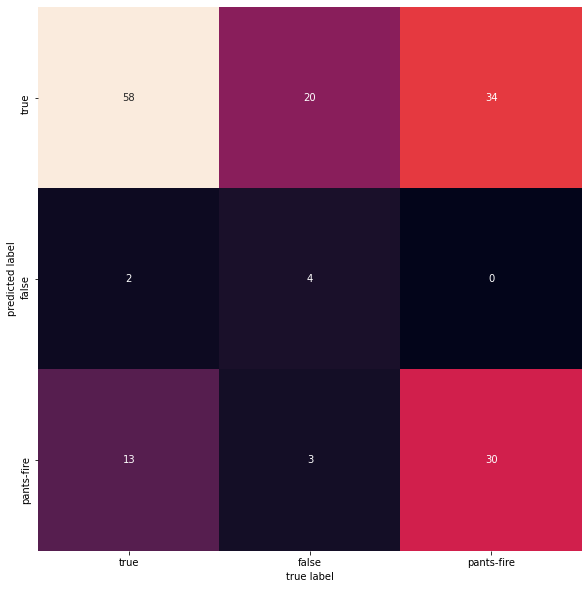

Train score: 0.963265306122449
Test score: 0.5609756097560976


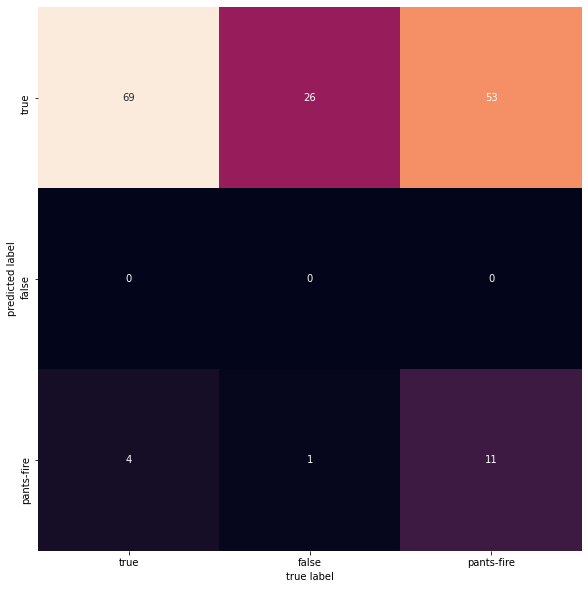

Train score: 0.7816326530612245
Test score: 0.4878048780487805


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [126]:
train_3labels, test_3labels = train_test_split(data_3labels)
label_names = train_3labels.Label.unique()
# Using count vectorizer
classification_report(train_3labels.Statement, train_3labels.Label, 
                      test_3labels.Statement, test_3labels.Label, label_names, count_vectorizer=True)
# Using TF-IDF vectorizer
classification_report(train_3labels.Statement, train_3labels.Label, 
                      test_3labels.Statement, test_3labels.Label, label_names, count_vectorizer=False)

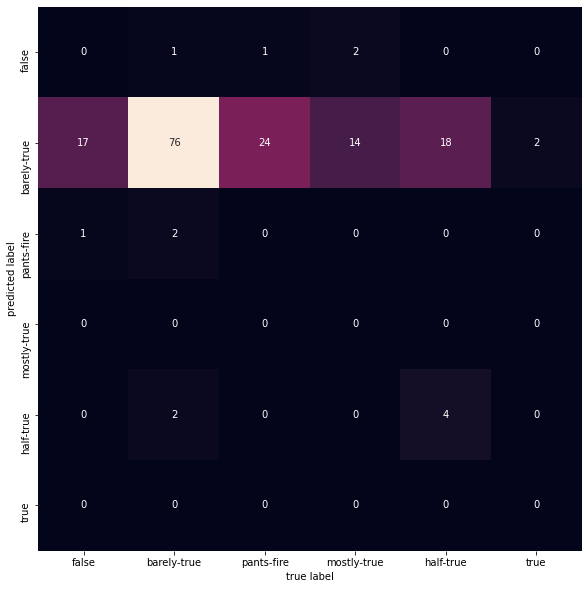

Train score: 0.8979591836734694
Test score: 0.4878048780487805


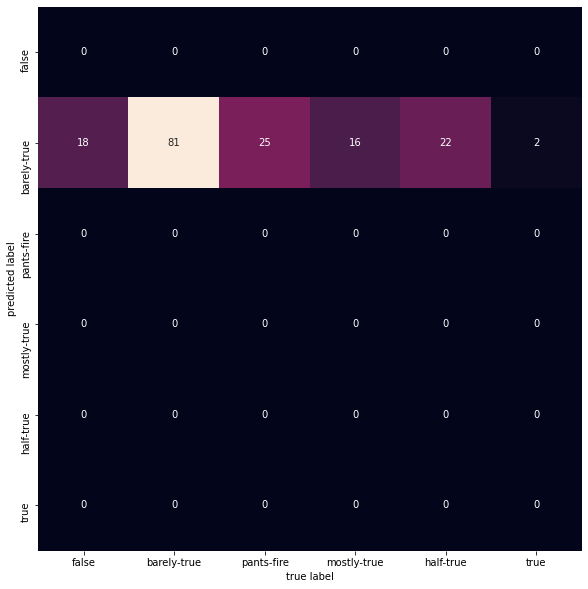

Train score: 0.48367346938775513
Test score: 0.49390243902439024


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [127]:
train, test = train_test_split(data)
label_names = train.Label.unique()
# Using count vectorizer
classification_report(train.Statement, train.Label, 
                      test.Statement, test.Label, label_names, count_vectorizer=True)
# Using TF-IDF vectorizer
classification_report(train.Statement, train.Label, 
                      test.Statement, test.Label, label_names, count_vectorizer=False)

#### Ordinal encoding

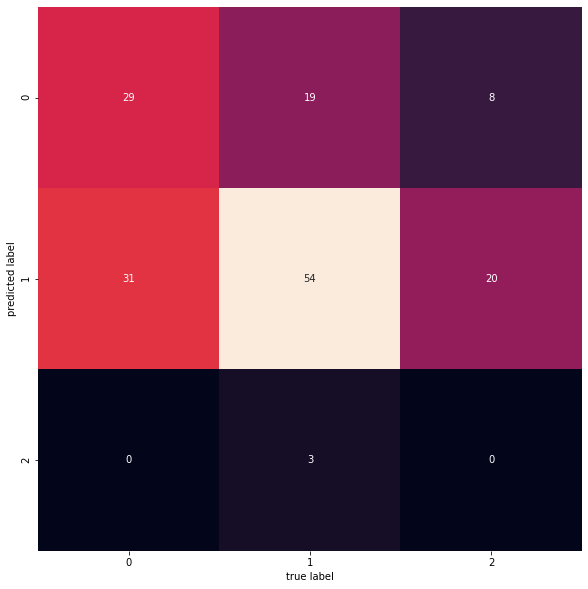

Train score: 0.9571428571428572
Test score: 0.5060975609756098


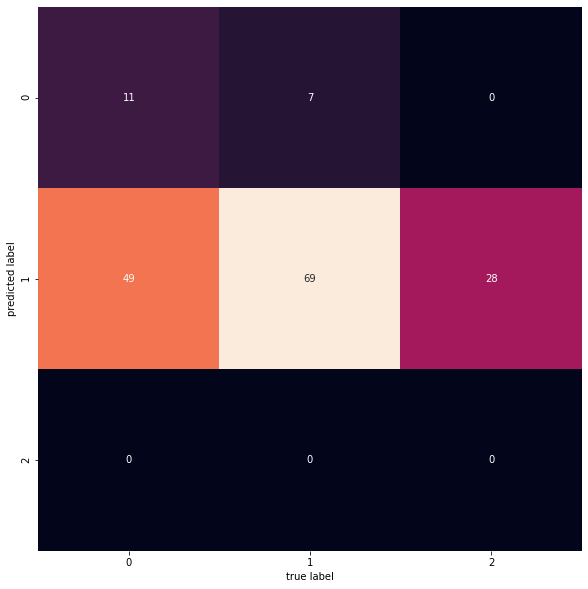

Train score: 0.8163265306122449
Test score: 0.4878048780487805


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [168]:
label_to_ordinal = {"true" : 0, "false" : 1, "pants-fire" : 2}
data_3labels_ordinal = data_3labels.copy()
for label in label_to_ordinal.keys():
    data_3labels_ordinal.Label = data_3labels_ordinal.Label.replace(label, label_to_ordinal[label])
    
label_names = [0, 1, 2]
    
train_3labels, test_3labels = train_test_split(data_3labels_ordinal)
# Using count vectorizer
model1 = classification_report(train_3labels.Statement, train_3labels.Label, 
                               test_3labels.Statement, test_3labels.Label, label_names, count_vectorizer=True)
# Using TF-IDF vectorizer
classification_report(train_3labels.Statement, train_3labels.Label, 
                      test_3labels.Statement, test_3labels.Label, label_names, count_vectorizer=False)

In [171]:
model1.predict(["coronavirus", "trump", "biden"])

array([1, 1, 1])

Cross-Validation??